In [1]:
#import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
#create an engine for the hawaii.sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table (Measurement and Station)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
#inspect the database to get the columns
inspector = inspect(engine)
measurement_columns = inspector.get_columns('Measurement')
station_columns = inspector.get_columns('Station')

In [9]:
#displays the column names of the Measurement table using a for loop
for mc in measurement_columns:
    print(mc['name'], mc["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#displays the column names of the Station table using a for loop
for sc in station_columns:
    print(sc['name'], sc["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

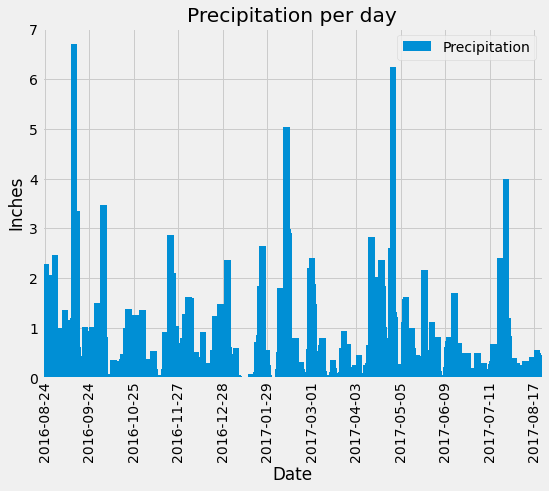

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#finds the last date by querying the dates of the measurement table and ordering them desending.Then collects the first value
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#converts this from string into datetime format so it can be used for calculations
datetime_object = dt.datetime.strptime(last_date[0], '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
query_date = datetime_object - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores of the last 12 months
twelve_months = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= query_date) .\
                order_by(Measurement.date.desc()).all()       
                              
# Save the query results as a Pandas DataFrame
pcrp_df = pd.DataFrame(twelve_months, columns=['Date', 'Precipitation'])

#sets Date column as the index
pcrp_df.set_index('Date', inplace=True)

# Sort the dataframe by date
pcrp_df.sort_values('Date', ascending = True, inplace = True)


# Use Pandas Plotting with Matplotlib to plot the data
ax = pcrp_df.plot(kind = "bar", width = 30, figsize = (8,6))

#display y label and title. x label automatically displayed due to the pandas.plot
ax.set_ylabel("Inches")
ax.set_title("Precipitation per day")


#limits the number of ticks shown
n = 200
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])

#ax.set_facecolor(('#f0f0f0'))
#ax.set_facecolor((1.0, 0.47, 0.42))

plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pcrp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
#use of function count in the query and .distinct to get the unique values
station_count = session.query(func.count(Station.station)).distinct().all()
station_count

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_active = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).distinct().\
                    order_by(func.count(Measurement.station).desc()).all()
station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
#collects the most active station to be used in the next query
most_active = station_active[0][0]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#func min to find lowest temp, func max to find highest and func avg to find average temp
temp_mc_station = session.query(Measurement.station, func.min(Measurement.tobs).label("min"), 
                    func.max(Measurement.tobs).label("max"), func.avg(Measurement.tobs).label("avg")).\
                    filter(Measurement.station == most_active).all()

temp_mc_station 

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [17]:
#convert to dictionary to display the key of the min, max and avg
temp_mc_station2 = [r._asdict() for r in temp_mc_station]

temp_mc_station2

[{'station': 'USC00519281',
  'min': 54.0,
  'max': 85.0,
  'avg': 71.66378066378067}]

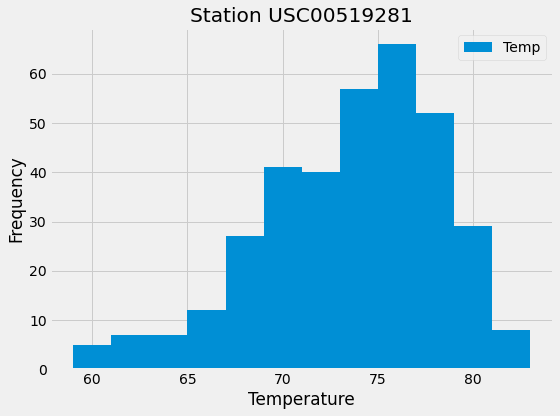

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_twelve_months = session.query(Measurement.date, Measurement.tobs) .\
                        filter(Measurement.date >= query_date) .\
                        filter(Measurement.station == most_active) .\
                        group_by(Measurement.date) .\
                        order_by(Measurement.date.desc()).all()   

#turns the query into a dataframe. names the columns and sets the index as the date
tobs_df = pd.DataFrame(station_twelve_months, columns=['Date', 'Temp'])
tobs_df.set_index('Date', inplace=True)


#plots the dataframe as histogram with setting the bins as 12
tobs_df.plot.hist(bins = 12, figsize = (8,6))

#plots the title and x label. y label automatically plotted. 
plt.title(f"Station {most_active}")
plt.xlabel("Temperature")
plt.tight_layout()
plt.show()